In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 55.4 MB/s 
     |████████████████████████████████| 6.6 MB 51.5 MB/s 
     |████████████████████████████████| 101 kB 10.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [10]:
# for uncompressing the .zip file

"""
import zipfile
with zipfile.ZipFile("/content/Akhbarona.zip","r") as zip_ref:
    zip_ref.extractall("/content/akhbarna/")
"""


'\nimport zipfile\nwith zipfile.ZipFile("/content/Akhbarona.zip","r") as zip_ref:\n    zip_ref.extractall("/content/akhbarna/")\n'

In [3]:
import string
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import re
import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import glob
import gc
import tensorflow as tf
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.layers as lay
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import sklearn

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Reading data

In [5]:
number_of_samples=2000
dataset_path="/content/akhbarna"

classes={}
i=0
for category in glob.glob(dataset_path+"/*"):
  classes[ category.split("/")[-1] ]=i
  i+=1

data=pd.DataFrame(columns=["text","class"])

for category in glob.glob(dataset_path+"/*"):
  if os.path.isfile(category):
    continue
  files=glob.glob(category+"/*.txt")[:number_of_samples]
  for sample_file in files:
    with open(sample_file) as f:
      text = f.read()
      clas=classes[ category.split("/")[-1] ]
      data = pd.concat([ data , pd.DataFrame([ [text,clas] ], columns=data.columns) ], ignore_index=True)
  
  print(category.split("/")[-1]+" samples loaded !\n")



Finance samples loaded !

Religion samples loaded !

Politics samples loaded !

Medical samples loaded !

Tech samples loaded !

Sports samples loaded !

Culture samples loaded !



In [ ]:
# Save , load the data

#data.to_csv('/content/drive/MyDrive/data/akhbarna/akhbarna.csv', index=False)
#data=pd.read_csv('/content/drive/MyDrive/data/akhbarna/akhbarna.csv')


## preprocess data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment")
model = TFAutoModelForSequenceClassification.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment",output_hidden_states=True)

Some layers from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_113']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [11]:
sw=stopwords.words('arabic')
def clean_text(txt):
 
  f=re.sub("[{}،ـ]+".format(string.punctuation), ' ', txt)
  f=re.sub("[a-zA-Z0-9]+", ' ', f)
  f=re.sub("\n", ' ', f)
  f=re.sub("\s+", ' ', f)

  #removing stop words
  tokens = f.split(" ")
  stopped_tokens = [i for i in tokens if not i in sw]
  f=" ".join(stopped_tokens)
  return f

def convert_text_to_vector(txt,using_max_lengh,manual_lengh):
  tokenized_text = tokenizer(
      txt,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="tf",
  )
  out=model(tokenized_text)
  #out[1] -> extract the hidden layers ( 1 input layer and 12 hidden bert layers )
  #out[1][-4:] -> extract last 4 layers 
  #concatenate the layers
  #summing all tokens vectors acroos the layers
  #taking the tokens only ( first and last tokens are CLS and SEP -> tokens added by bert )
  words_vectors=np.sum(tf.concat(out[1][-4:],axis=0).numpy(),axis=0)[1:-1]
 

  #if using_max_lengh=False so we manually set our lengh
  if using_max_lengh==False:
    number_added_rows= manual_lengh-words_vectors.shape[0]

    # if padding value is negative so it means truncting (this case happens with manual_lengh only)
    if number_added_rows<0:
      words_vectors=words_vectors[:manual_lengh].tolist()
    else:
      added_rows=np.zeros((number_added_rows,words_vectors.shape[1]))
      words_vectors=np.concatenate((words_vectors, added_rows), axis=0).tolist()
      
  return words_vectors


def get_max_lengh(arr):
  max_lenght=0
  for vec in arr:
    if  vec.shape[0]> max_lenght:
      max_lenght=vec.shape[0]

  return max_lenght


def padding(vec,padding_lengh):
  number_added_rows= padding_lengh-vec.shape[0]
  added_rows=np.zeros((number_added_rows,vec.shape[1]))
  new_vec=np.concatenate((vec, added_rows), axis=0).tolist()
  return new_vec

In [ ]:
def preprocess_data(df,manual_lengh=100,output_dim_bert=768,using_max_lengh=False):
  # 1 - clean data
  # 2 - convert text to vectors
  # 3 - padding or truncting

  if using_max_lengh:
    x_list=[]
    y=np.zeros((df.shape[0],len(classes)))

    for index, row in df.iterrows():
      txt=row['text']
      classoftext= row['class']

      txt=clean_text(txt)
      vec=convert_text_to_vector(txt,using_max_lengh,manual_lengh)
      x_list.append(vec)
      y[index]=to_categorical(classoftext,num_classes=len(classes))

    max_lengh=get_max_lengh(x_list)
    x=np.zeros((df.shape[0],max_lengh,output_dim_bert))
    i=0
    for arr in x_list:
      x[i,:,:]=padding(arr,max_lengh)
      i+=1


  else:
    x=np.zeros((df.shape[0],manual_lengh,output_dim_bert))
    y=np.zeros((df.shape[0],len(classes)))

    for index, row in df.iterrows():
      txt=row['text']
      classoftext= row['class']

      txt=clean_text(txt)
      vec=convert_text_to_vector(txt,using_max_lengh,manual_lengh)
      x[index,:,:]=vec
      y[index]=to_categorical(classoftext,num_classes=len(classes))
    
  x, y = shuffle(x, y, random_state=42)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
  return x_train, x_test, y_train, y_test 

In [ ]:
x_train, x_test, y_train, y_test =preprocess_data(data,manual_lengh=100,output_dim_bert=768,using_max_lengh=False)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(12600, 100, 768)
(1400, 100, 768)
(12600, 7)
(1400, 7)


# Training diffrent tequniques

### 1- Bert as word emdding model + ( LSTM ,GRU ,Bidirectional-LSTM )

In [ ]:
def create_train_model(time_layers,x_train,y_train,x_test,y_test,epochs,batch_size,verbose):
    #clearing some memory
    gc.collect()

    #building model and train it
    inpt=lay.Input((x_train.shape[1],x_train.shape[2]))
    l1=time_layers[0](inpt)
    for layer in time_layers[1:]:
      l1=layer(l1)
    d1=lay.Dense(32)(l1)
    d2=lay.Dense(7,activation="softmax")(d1)
    nural_network=tf.keras.Model(inputs=inpt,outputs=d2)

    nural_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.categorical_crossentropy
                 ,metrics=["accuracy"])
    history=nural_network.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=batch_size,epochs=epochs,verbose=verbose)

    return history



In [ ]:
layers_lstm=[lay.LSTM(128),lay.Dropout(0.2)]
history_lstm=create_train_model(layers_lstm,x_train,y_train,x_test,y_test,epochs=30,batch_size=16,verbose=0)

In [ ]:
layers_gru=[lay.GRU(128),lay.Dropout(0.2)]
history_gru=create_train_model(layers_gru,x_train,y_train,x_test,y_test,epochs=30,batch_size=16,verbose=0)

In [ ]:
layers_bi_lstm=[ lay.Bidirectional( lay.LSTM( 128 ) ),lay.Dropout(0.2) ]
history_lstm_biedirectional=create_train_model(layers_bi_lstm,x_train,y_train,x_test,y_test,epochs=30,batch_size=16,verbose=0)

In [ ]:
gc.collect()

1145

In [6]:
def show_results(history,title):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

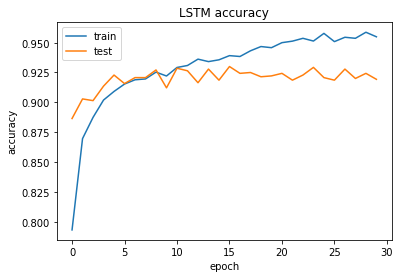

In [ ]:
show_results(history_lstm,"LSTM")

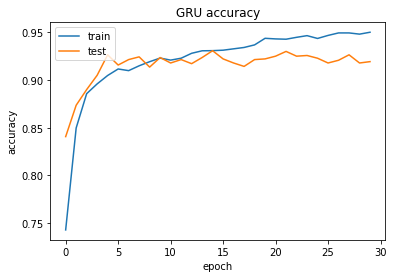

In [ ]:
show_results(history_gru,"GRU")

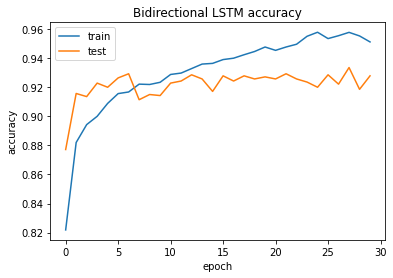

In [ ]:
show_results(history_lstm_biedirectional,"Bidirectional LSTM")

### 2-Fine tuning bert model with custom layers

In [7]:
tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment")
model = TFAutoModelForSequenceClassification.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment",output_hidden_states=True)

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/297k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some layers from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_113']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [8]:
# make only last 2 layers in bert are trainable
for layer in model.layers[:-2]:
  layer.trainable=False

for layer in model.layers[-2:]:
  layer.trainable=True


In [12]:
#tokenizing the data
tokenized_text = tokenizer(
        data["text"].apply(clean_text).tolist(),
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf",
    )

In [13]:
y_bert_fine_tune=to_categorical( data["class"].tolist() )

In [14]:
x_input_ids=tokenized_text['input_ids'].numpy()
x_attention_mask=tokenized_text['attention_mask'].numpy()

In [15]:
x_input_ids,x_attention_mask, y_bert_fine_tune = shuffle(x_input_ids,x_attention_mask, y_bert_fine_tune, random_state=0)

In [16]:
x_input_ids_train, x_input_ids_test,x_attention_mask_train, x_attention_mask_test,y_bert_fine_tune_train , y_bert_fine_tune_test= train_test_split(x_input_ids, x_attention_mask,y_bert_fine_tune, test_size=0.1, random_state=42)

In [17]:
inpt1=tf.keras.layers.Input(shape=(None,),dtype=tf.int64)
inpt2=tf.keras.layers.Input(shape=(None,),dtype=tf.int64)
out=model([inpt1,inpt2])
d1=tf.keras.layers.Dense(7,activation="softmax")(out[1][-1][:,0,:])
custom_model=tf.keras.Model(inputs=[inpt1,inpt2],outputs=d1)

In [18]:
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.categorical_crossentropy
                     ,metrics=["accuracy"])

In [19]:
history_bert=custom_model.fit(x=[ x_input_ids_train,x_attention_mask_train ],
                 y=y_bert_fine_tune_train,epochs=30,batch_size=128,
                 validation_data=( (x_input_ids_test,x_attention_mask_test), y_bert_fine_tune_test)
                 ,verbose=1)

Epoch 1/30
99/99 [==============================] - 374s 4s/step - loss: 0.9558 - accuracy: 0.6724 - val_loss: 0.5144 - val_accuracy: 0.8350
Epoch 2/30
99/99 [==============================] - 354s 4s/step - loss: 0.5222 - accuracy: 0.8324 - val_loss: 0.4074 - val_accuracy: 0.8679
Epoch 3/30
99/99 [==============================] - 354s 4s/step - loss: 0.4628 - accuracy: 0.8506 - val_loss: 0.3599 - val_accuracy: 0.8850
Epoch 4/30
99/99 [==============================] - 354s 4s/step - loss: 0.4176 - accuracy: 0.8649 - val_loss: 0.3496 - val_accuracy: 0.8843
Epoch 5/30
99/99 [==============================] - 353s 4s/step - loss: 0.4036 - accuracy: 0.8672 - val_loss: 0.3279 - val_accuracy: 0.9000
Epoch 6/30
99/99 [==============================] - 353s 4s/step - loss: 0.3878 - accuracy: 0.8740 - val_loss: 0.3167 - val_accuracy: 0.8993
Epoch 7/30
99/99 [==============================] - 353s 4s/step - loss: 0.3760 - accuracy: 0.8745 - val_loss: 0.3213 - val_accuracy: 0.8950
Epoch 8/30
99

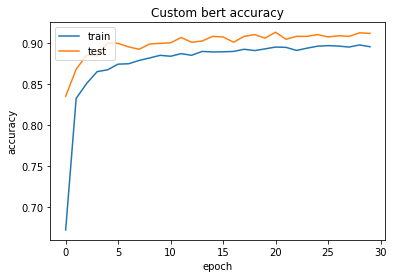

In [20]:
show_results(history_bert,"Custom bert")